In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pulp import *

In [69]:
inputs = pd.read_csv('inputs.csv', index_col=0, delimiter=';')
outputs = pd.read_csv('outputs.csv', index_col=0, delimiter=';')
samples = pd.read_csv('samples_homework.csv', delimiter=';')

In [70]:
efficiency_scores = {}
reference_units = {}
adjustments = {}
super_efficiency_scores = {}
cross_efficiency_scores = {DMU: [] for DMU in inputs.index}
expected_efficiency = {}

In [71]:
# Calculate efficiency and super-efficiency for each DMU
for DMUo in inputs.index:
    problem = LpProblem(f"Efficiency_{DMUo}", LpMinimize)
    lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
    theta = LpVariable("theta", lowBound=0, upBound=1)

    problem += theta

    for input_metric in inputs.columns:
        problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric]

    for output_metric in outputs.columns:
        problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] for i in outputs.index]) >= outputs.loc[DMUo, output_metric]

    problem.solve(PULP_CBC_CMD(msg=False))

    if LpStatus[problem.status] == 'Optimal':
        efficiency_score = pulp.value(theta)
        efficiency_scores[DMUo] = efficiency_score

        if efficiency_score < 1:
            reference_units[DMUo] = {}
            adjustments[DMUo] = {}
            for i in inputs.index:
                if lambdas[i].varValue > 0:
                    reference_units[DMUo][i] = lambdas[i].varValue

            for input_metric in inputs.columns:
                optimal_input = sum(lambdas[i].varValue * inputs.loc[i, input_metric] for i in inputs.index)
                adjustments[DMUo][input_metric] = optimal_input

    else:
        print(f"Problem for {DMUo} is not solvable")
    
    # Superefektywność
    super_problem = LpProblem(f"SuperEfficiency_{DMUo}", LpMinimize)
    super_lambdas = LpVariable.dicts("SuperLambda", (i for i in inputs.index if i != DMUo), lowBound=0)
    super_theta = LpVariable("super_theta", lowBound=0)

    super_problem += super_theta
    for input_metric in inputs.columns:
        super_problem += lpSum([super_lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index if i != DMUo]) <= super_theta * inputs.loc[DMUo, input_metric]
    for output_metric in outputs.columns:
        super_problem += lpSum([super_lambdas[i] * outputs.loc[i, output_metric] for i in outputs.index if i != DMUo]) >= outputs.loc[DMUo, output_metric]
    
    super_problem.solve(PULP_CBC_CMD(msg=False))
    if LpStatus[super_problem.status] == 'Optimal':
        super_efficiency_scores[DMUo] = 1 / pulp.value(super_theta)

# Calculate cross-efficiency and expected efficiency
for DMUo in inputs.index:
    all_efficiencies = []  # Initialize a list to store efficiencies for the current DMU
    for index, sample in samples.iterrows():
        problem = LpProblem(f"SampleEfficiency_{DMUo}_{index}", LpMinimize)
        lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
        theta = LpVariable("theta", lowBound=0, upBound=1)
        
        problem += theta
        for input_metric in inputs.columns:
            problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] * sample[input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric] * sample[input_metric]
        for output_metric in outputs.columns:
            problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] * sample[output_metric] for i in outputs.index]) >= outputs.loc[DMUo, output_metric] * sample[output_metric]
    
        problem.solve(PULP_CBC_CMD(msg=False))
        if LpStatus[problem.status] == 'Optimal':
            all_efficiencies.append(pulp.value(theta))

    cross_efficiency_scores[DMUo].extend(all_efficiencies)
    expected_efficiency[DMUo] = np.mean(all_efficiencies)

# Display the results
for airport, efficiency in efficiency_scores.items():
    print(f"Efficiency for {airport}: {efficiency:.2f}")
    if airport in super_efficiency_scores:
        print(f"Super Efficiency for {airport}: {super_efficiency_scores[airport]:.2f}")
    if airport in adjustments:
        print(f"Adjustments for {airport}:")
        for metric, value in adjustments[airport].items():
            print(f"  {metric}: reduce to {value:.2f}")
    print(f"Expected Efficiency for {airport}: {expected_efficiency[airport]:.2f}")


Efficiency for WAW: 1.00
Super Efficiency for WAW: 0.44
Expected Efficiency for WAW: 1.00
Efficiency for KRK: 1.00
Super Efficiency for KRK: 0.89
Expected Efficiency for KRK: 1.00
Efficiency for KAT: 0.59
Super Efficiency for KAT: 1.69
Adjustments for KAT:
  i1: reduce to 2.13
  i2: reduce to 18.92
  i3: reduce to 33.94
  i4: reduce to 4.40
Expected Efficiency for KAT: 0.59
Efficiency for WRO: 1.00
Super Efficiency for WRO: 0.96
Expected Efficiency for WRO: 1.00
Efficiency for POZ: 0.80
Super Efficiency for POZ: 1.25
Adjustments for POZ:
  i1: reduce to 1.20
  i2: reduce to 8.00
  i3: reduce to 19.20
  i4: reduce to 1.93
Expected Efficiency for POZ: 0.80
Efficiency for LCJ: 0.30
Super Efficiency for LCJ: 3.33
Adjustments for LCJ:
  i1: reduce to 0.18
  i2: reduce to 2.78
  i3: reduce to 7.20
  i4: reduce to 0.47
Expected Efficiency for LCJ: 0.30
Efficiency for GDN: 1.00
Super Efficiency for GDN: 0.50
Expected Efficiency for GDN: 1.00
Efficiency for SZZ: 0.27
Super Efficiency for SZZ: 3

In [79]:
# Create DataFrame for ranking
results_df = pd.DataFrame({
    'Efficiency': pd.Series(efficiency_scores),
    'SuperEfficiency': pd.Series(super_efficiency_scores),
    'ExpectedEfficiency': pd.Series(expected_efficiency)
})

# Rank units
results_df['EfficiencyRank'] = results_df['Efficiency'].rank(ascending=False)
results_df['SuperEfficiencyRank'] = results_df['SuperEfficiency'].rank(ascending=False)
results_df['ExpectedEfficiencyRank'] = results_df['ExpectedEfficiency'].rank(ascending=False)

# Display the rankings
results_df.sort_values(by='EfficiencyRank', inplace=True)
print("Rankings based on Efficiency, SuperEfficiency, and ExpectedEfficiency:")
print(results_df)

# Analyze the ranking consistency
results_df['EfficiencyRank'] = results_df['EfficiencyRank'].astype(int)
results_df['SuperEfficiencyRank'] = results_df['SuperEfficiencyRank'].astype(int)
results_df['ExpectedEfficiencyRank'] = results_df['ExpectedEfficiencyRank'].astype(int)

# Calculate Spearman rank correlation to check consistency
efficiency_super_corr = results_df[['EfficiencyRank', 'SuperEfficiencyRank']].corr(method='spearman').iloc[0, 1]
efficiency_expected_corr = results_df[['EfficiencyRank', 'ExpectedEfficiencyRank']].corr(method='spearman').iloc[0, 1]
super_expected_corr = results_df[['SuperEfficiencyRank', 'ExpectedEfficiencyRank']].corr(method='spearman').iloc[0, 1]

print(f"Spearman rank correlation between Efficiency and SuperEfficiency: {efficiency_super_corr:.2f}")
print(f"Spearman rank correlation between Efficiency and ExpectedEfficiency: {efficiency_expected_corr:.2f}")
print(f"Spearman rank correlation between SuperEfficiency and ExpectedEfficiency: {super_expected_corr:.2f}")


Rankings based on Efficiency, SuperEfficiency, and ExpectedEfficiency:
     Efficiency  SuperEfficiency  ExpectedEfficiency  EfficiencyRank  \
WAW    1.000000         0.438991            1.000000             3.0   
KRK    1.000000         0.889852            1.000000             3.0   
WRO    1.000000         0.961589            1.000000             3.0   
GDN    1.000000         0.500000            1.000000             3.0   
BZG    1.000000         0.572760            1.000000             3.0   
POZ    0.799801         1.250311            0.799801             6.0   
KAT    0.591209         1.691449            0.591209             7.0   
RZE    0.409183         2.443892            0.409183             8.0   
LCJ    0.300036         3.332931            0.300036             9.0   
SZZ    0.270787         3.692936            0.270787            10.0   
IEG    0.258475         3.868852            0.258475            11.0   

     SuperEfficiencyRank  ExpectedEfficiencyRank  
WAW          

In [80]:
# Explanation for (dis)agreement in rankings
explanation = """
The agreement or disagreement in rankings can be attributed to the different perspectives each measure provides:
1. Efficiency: Measures how well a DMU converts inputs into outputs within its own context.
2. SuperEfficiency: Evaluates the DMU's performance relative to all other units except itself, potentially identifying it as a strong outlier.
3. ExpectedEfficiency: Considers variations in inputs and outputs, providing an average efficiency under different scenarios.

Differences in rankings can occur due to:
- Variations in data samples used for expected efficiency.
- Super-efficiency might highlight a DMU's outlier status more strongly than basic efficiency.
- The inherent variability and uncertainty captured in the expected efficiency that might not be present in the static efficiency scores.
"""

print(explanation)


The agreement or disagreement in rankings can be attributed to the different perspectives each measure provides:
1. Efficiency: Measures how well a DMU converts inputs into outputs within its own context.
2. SuperEfficiency: Evaluates the DMU's performance relative to all other units except itself, potentially identifying it as a strong outlier.
3. ExpectedEfficiency: Considers variations in inputs and outputs, providing an average efficiency under different scenarios.

Differences in rankings can occur due to:
- Variations in data samples used for expected efficiency.
- Super-efficiency might highlight a DMU's outlier status more strongly than basic efficiency.
- The inherent variability and uncertainty captured in the expected efficiency that might not be present in the static efficiency scores.



Efficiency Distribution for Each DMU:
     Bin_1  Bin_2  Bin_3  Bin_4  Bin_5
WAW      0      0      0      0    100
KRK      0      0      0      0    100
KAT      0      0    100      0      0
WRO      0      0      0      0    100
POZ      0      0      0    100      0
LCJ      0    100      0      0      0
GDN      0      0      0      0    100
SZZ      0    100      0      0      0
BZG      0      0      0      0    100
RZE      0      0    100      0      0
IEG      0    100      0      0      0


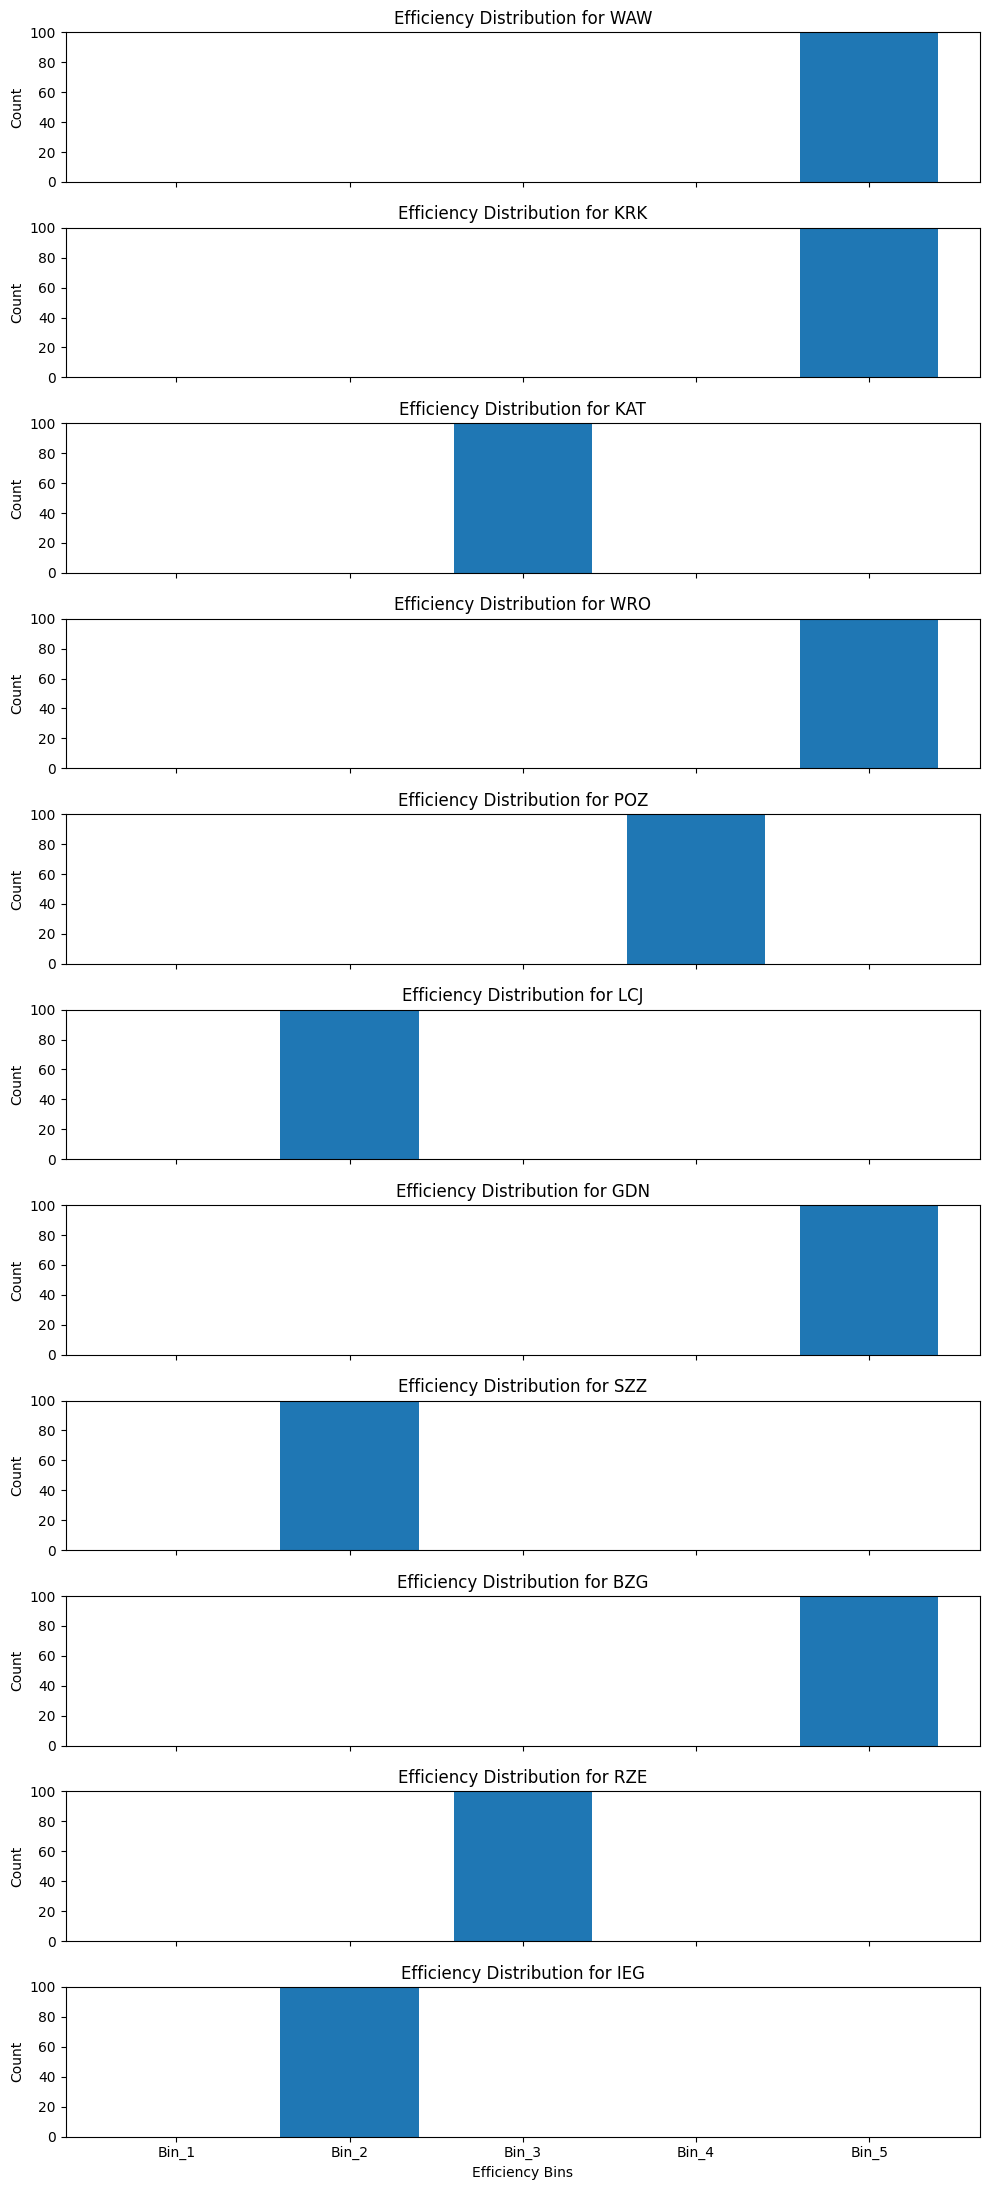

In [81]:
# Divide efficiencies into 5 equal bins and count occurrences
bins = np.linspace(0, 1, 6)
efficiency_distributions = {DMU: np.histogram(cross_efficiency_scores[DMU], bins=bins)[0] for DMU in inputs.index}

# Create DataFrame for distribution
distribution_df = pd.DataFrame(efficiency_distributions).T
distribution_df.columns = [f'Bin_{i}' for i in range(1, 6)]

# Display the distribution
print("Efficiency Distribution for Each DMU:")
print(distribution_df)

# Plot the distributions for each DMU
fig, axs = plt.subplots(len(inputs.index), 1, figsize=(10, len(inputs.index)*2), sharex=True)

for idx, DMU in enumerate(inputs.index):
    axs[idx].bar(distribution_df.columns, distribution_df.loc[DMU])
    axs[idx].set_title(f'Efficiency Distribution for {DMU}')
    axs[idx].set_ylabel('Count')
    axs[idx].set_ylim(0, max(distribution_df.max()))

plt.xlabel('Efficiency Bins')
plt.tight_layout()
plt.show()